In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import shap
import seaborn as sns 
import matplotlib.pyplot as plt

# Assuming df is your DataFrame after aggregating to daily data and merging with weather/building data
df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# Get the number of rows and columns 
# rows = len(df.axes[0]) 
# cols = len(df.axes[1]) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41666 entries, 0 to 41665
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               41664 non-null  object 
 1   Comms and Services                 40812 non-null  float64
 2   Car Chargers                       40812 non-null  float64
 3   Space Heating                      40812 non-null  float64
 4   Hot Water                          40812 non-null  float64
 5   Sockets                            40812 non-null  float64
 6   Lighting                           40812 non-null  float64
 7   total_energy                       41664 non-null  object 
 8   datepart                           41664 non-null  float64
 9   weekend                            41664 non-null  object 
 10  bank holiday                       41664 non-null  object 
 11  hour                               41664 non-null  flo

C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_41744\267611544.py:17: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"


In [19]:
# Generate a list of columns to drop
columns_to_drop = [col for col in df.columns if col.startswith('observation')]

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               40131 non-null  object 
 1   Comms and Services                 40131 non-null  float64
 2   Car Chargers                       40131 non-null  float64
 3   Space Heating                      40131 non-null  float64
 4   Hot Water                          40131 non-null  float64
 5   Sockets                            40131 non-null  float64
 6   Lighting                           40131 non-null  float64
 7   total_energy                       40131 non-null  object 
 8   datepart                           40131 non-null  float64
 9   weekend                            40131 non-null  object 
 10  bank holiday                       40131 non-null  object 
 11  hour                               40131 non-null  float6

In [20]:
#Defining Function for turning features into cyclic 
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [21]:


# df['month'] = df.datetime.dt.month
df = encode(df, 'month', 12)
df =  encode(df, 'hour', 24)
# df['day'] = df.datetime.dt.day
# df = encode(df, 'day', 31)
df = encode(df, 'day of week', 7)
df = encode(df, 'day of month', 31)
df['working_hours'] = df['hour'].apply(lambda x: 8 <= x <= 17)

In [22]:
df['bank holiday'] = df['bank holiday'].astype(int)

In [23]:
# Feature Engineering
# Add temporal features (e.g., day of week, month)
# df['Day of week'] = df['Day of week'].dt.dayofweek
# df['Month'] = df['Month'].dt.month

# Check if 'Weekend' is False
df['weekend'] = df['weekend'].astype(int)


In [24]:
df

time  Comms and Services  Car Chargers  \
112    2019-04-05 16:00:00+00            0.590111      0.043272   
113    2019-04-05 17:00:00+00            0.590689      0.043253   
115    2019-04-05 19:00:00+00            0.590050      0.043139   
116    2019-04-05 20:00:00+00            0.589536      0.043031   
119    2019-04-05 23:00:00+00            0.589953      0.043239   
...                       ...                 ...           ...   
41659  2023-12-31 19:00:00+00            0.431266      0.000000   
41660  2023-12-31 20:00:00+00            0.431275      0.000000   
41661  2023-12-31 21:00:00+00            0.432384      0.000000   
41662  2023-12-31 22:00:00+00            0.431819      0.000000   
41663  2023-12-31 23:00:00+00            0.432600      0.000000   

       Space Heating  Hot Water   Sockets  Lighting total_energy  datepart  \
112         2.564617   0.076094  0.077019  0.756983  4.108097218   43560.0   
113         2.639575   0.000000  0.048581  0.208511  3.530608334   43560.0   
115         1.168772   0.000000  0.052336  0.151611  2.005908333   43560.0   
116         0.916325   0.000000  0.046442  0.151839  1.747172223   43560.0   
119         0.953847   0.087725  0.067442  0.173542  1.915747223   43560.0   
...              ...        ...       ...       ...          ...       ...   
41659       0.315221   0.000000  0.099255  0.233618  1.079359429   45291.0   
41660       1.168081   0.429653  0.103842  0.232898  2.365749757   45291.0   
41661       1.634023   0.000000  0.096170  0.213528   2.37610544   45291.0   
41662       1.580730   0.000000  0.100618  0.228981  2.342148396   45291.0   
41663       1.291073   0.000000  0.096448  0.213284  2.033403901   45291.0   

       weekend  ...  forecast_interval     month_sin  month_cos  hour_sin  \
112          0  ...           23:00:00  8.660254e-01       -0.5 -0.866025   
113          0  ...           22:00:00  8.660254e-01       -0.5 -0.965926   
115          0  ...           23:00:00  8.660254e-01       -0.5 -0.965926   
116          0  ...           22:00:00  8.660254e-01       -0.5 -0.866025   
119          0  ...           22:00:00  8.660254e-01       -0.5 -0.258819   
...        ...  ...                ...           ...        ...       ...   
41659        1  ...           23:00:00 -2.449294e-16        1.0 -0.965926   
41660        1  ...           22:00:00 -2.449294e-16        1.0 -0.866025   
41661        1  ...              1 day -2.449294e-16        1.0 -0.707107   
41662        1  ...           23:00:00 -2.449294e-16        1.0 -0.500000   
41663        1  ...           22:00:00 -2.449294e-16        1.0 -0.258819   

       hour_cos  day of week_sin day of week_cos day of month_sin  \
112   -0.500000        -0.974928       -0.222521     8.486443e-01   
113   -0.258819        -0.974928       -0.222521     8.486443e-01   
115    0.258819        -0.974928       -0.222521     8.486443e-01   
116    0.500000        -0.974928       -0.222521     8.486443e-01   
119    0.965926        -0.974928       -0.222521     8.486443e-01   
...         ...              ...             ...              ...   
41659  0.258819         0.000000        1.000000    -2.449294e-16   
41660  0.500000         0.000000        1.000000    -2.449294e-16   
41661  0.707107         0.000000        1.000000    -2.449294e-16   
41662  0.866025         0.000000        1.000000    -2.449294e-16   
41663  0.965926         0.000000        1.000000    -2.449294e-16   

       day of month_cos  working_hours  
112            0.528964           True  
113            0.528964           True  
115            0.528964          False  
116            0.528964          False  
119            0.528964          False  
...                 ...            ...  
41659          1.000000          False  
41660          1.000000          False  
41661          1.000000          False  
41662          1.000000          False  
41663          1.000000          False  

[40131 rows x 36 columns]

In [25]:
columns_to_convert = ['weekend','bank holiday']

# Convert 0 and 1 to boolean values in specified columns
df[columns_to_convert] = df[columns_to_convert].astype(bool)
# Sum specified columns to create 'total_aob_energy'
df['total_aob_energy'] = df[['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting']].sum(axis=1, skipna=True)

# Drop the original columns except 'Car Chargers'
df.drop(['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting','day of week','day of month','hour','month' ], axis=1, inplace=True)

# Now, 'df' contains the new 'total_aob_energy' column and has the specified columns dropped, except 'Car Chargers'

In [26]:
df.head()

time  Car Chargers total_energy  datepart  weekend  \
112  2019-04-05 16:00:00+00      0.043272  4.108097218   43560.0    False   
113  2019-04-05 17:00:00+00      0.043253  3.530608334   43560.0    False   
115  2019-04-05 19:00:00+00      0.043139  2.005908333   43560.0    False   
116  2019-04-05 20:00:00+00      0.043031  1.747172223   43560.0    False   
119  2019-04-05 23:00:00+00      0.043239  1.915747223   43560.0    False   

     bank holiday    year       forecast_datadate          forecastperiod  \
112         False  2019.0  2019-04-05 16:00:00+00  2019-04-06 15:00:00+00   
113         False  2019.0  2019-04-05 17:00:00+00  2019-04-06 15:00:00+00   
115         False  2019.0  2019-04-05 19:00:00+00  2019-04-06 18:00:00+00   
116         False  2019.0  2019-04-05 20:00:00+00  2019-04-06 18:00:00+00   
119         False  2019.0  2019-04-05 23:00:00+00  2019-04-06 21:00:00+00   

     forecast_temperature  ...  month_sin  month_cos  hour_sin  hour_cos  \
112                  13.0  ...   0.866025       -0.5 -0.866025 -0.500000   
113                  13.0  ...   0.866025       -0.5 -0.965926 -0.258819   
115                  12.0  ...   0.866025       -0.5 -0.965926  0.258819   
116                  12.0  ...   0.866025       -0.5 -0.866025  0.500000   
119                  10.0  ...   0.866025       -0.5 -0.258819  0.965926   

     day of week_sin day of week_cos day of month_sin day of month_cos  \
112        -0.974928       -0.222521         0.848644         0.528964   
113        -0.974928       -0.222521         0.848644         0.528964   
115        -0.974928       -0.222521         0.848644         0.528964   
116        -0.974928       -0.222521         0.848644         0.528964   
119        -0.974928       -0.222521         0.848644         0.528964   

     working_hours  total_aob_energy  
112           True          4.064825  
113           True          3.487356  
115          False          1.962769  
116          False          1.704142  
119          False          1.872508  

[5 rows x 28 columns]

In [27]:
df['time'] = pd.to_datetime(df['time'])

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   time                               40131 non-null  datetime64[ns, UTC]
 1   Car Chargers                       40131 non-null  float64            
 2   total_energy                       40131 non-null  object             
 3   datepart                           40131 non-null  float64            
 4   weekend                            40131 non-null  bool               
 5   bank holiday                       40131 non-null  bool               
 6   year                               40131 non-null  float64            
 7   forecast_datadate                  40131 non-null  object             
 8   forecastperiod                     40131 non-null  object             
 9   forecast_temperature               40131 non-null  fl

In [29]:
df = df.dropna()
df = df.select_dtypes(exclude=['object'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   time                               40131 non-null  datetime64[ns, UTC]
 1   Car Chargers                       40131 non-null  float64            
 2   datepart                           40131 non-null  float64            
 3   weekend                            40131 non-null  bool               
 4   bank holiday                       40131 non-null  bool               
 5   year                               40131 non-null  float64            
 6   forecast_temperature               40131 non-null  float64            
 7   forecast_feelslike                 40131 non-null  float64            
 8   forecast_weathertype               40131 non-null  float64            
 9   forecast_windspeed                 40131 non-null  fl

In [30]:
df.columns = [col.capitalize() for col in df.columns]
print(df.columns)
df.info()

Index(['Time', 'Car chargers', 'Datepart', 'Weekend', 'Bank holiday', 'Year',
       'Forecast_temperature', 'Forecast_feelslike', 'Forecast_weathertype',
       'Forecast_windspeed', 'Forecast_uvindex',
       'Forecast_precipitationprobability', 'Month_sin', 'Month_cos',
       'Hour_sin', 'Hour_cos', 'Day of week_sin', 'Day of week_cos',
       'Day of month_sin', 'Day of month_cos', 'Working_hours',
       'Total_aob_energy'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   Time                               40131 non-null  datetime64[ns, UTC]
 1   Car chargers                       40131 non-null  float64            
 2   Datepart                           40131 non-null  float64            
 3   Weekend                            40131 non-null  b

In [31]:
new_columns = []
for col in df.columns:
    # Remove "Forecast_" if it exists and capitalize the first letter of the remaining string
    if col.startswith('Forecast_'):
        new_name = col.replace('Forecast_', '')  # Remove 'Forecast_'
        new_name = new_name.capitalize()  # Capitalize the first letter
    else:
        new_name = col  # Keep the original name if it doesn't start with 'Forecast_'
    new_columns.append(new_name)

# Assign the modified column names back to the DataFrame
df.columns = new_columns


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Time                      40131 non-null  datetime64[ns, UTC]
 1   Car chargers              40131 non-null  float64            
 2   Datepart                  40131 non-null  float64            
 3   Weekend                   40131 non-null  bool               
 4   Bank holiday              40131 non-null  bool               
 5   Year                      40131 non-null  float64            
 6   Temperature               40131 non-null  float64            
 7   Feelslike                 40131 non-null  float64            
 8   Weathertype               40131 non-null  float64            
 9   Windspeed                 40131 non-null  float64            
 10  Uvindex                   40131 non-null  float64            
 11  Precipitationproba

In [33]:
# Split data into features and target
X = df.drop(['datepart','Car charger'], axis=1)  # Assuming 'energy_consumption' is the target variable
y = df['Car charger']
# X = df[['hour_sin','hour_cos','Car Chargers','forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# X = df[['forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Model Training
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

#gradient-boosted regression model
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)

#Ridge Model 
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

#Lasso Model
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

#Support Vector Regression 
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Model Evaluation
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gbr = gbr_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)


#https://stats.stackexchange.com/questions/255276/normalized-root-mean-square-error-nrmse-with-zero-mean-of-observed-value
#https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python
# Calculate range of the target variable
y_range = np.max(y_test) - np.min(y_test)
# Calculate the mean of the target variable
y_mean = np.mean(y_test)
# Calculate RMSE for Linear Regression
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_rmse = mean_squared_error(y_test, y_pred_lr, squared=False)

# Calculate Normalised RMSE for Linear Regression
#https://www.marinedatascience.co/blog/2019/01/07/normalizing-the-rmse/
lr_nrmse = lr_rmse / y_range
# Calculate rRMSE (relative RMSE) for Linear Regression, normalized by the mean of y_test
# https://search.r-project.org/CRAN/refmans/ehaGoF/html/gofRRMSE.html
lr_rrmse = lr_rmse / y_mean
# Calculate MAE
lr_mae = np.mean(np.abs(y_test - y_pred_lr))
print("Mean Absolute Error (MAE) for Linear Regression:", lr_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
lr_mape = np.mean(np.abs((y_test - y_pred_lr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Linear Regression:", lr_mape, "%")

print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression NRMSE:", lr_nrmse)
print("Linear Regression rRMSE:", lr_rrmse)



# Calculate normalised RMSE for Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# Calculate Normalised RMSE for Random Forest
rf_nrmse = rf_rmse / y_range
# Calculate rRMSE (relative RMSE) for Random Forest, normalised by the mean of y_test
rf_rrmse = rf_rmse / y_mean
# Calculate MAE
rf_mae = np.mean(np.abs(y_test - y_pred_rf))
print("Mean Absolute Error (MAE) for Random Forest:", rf_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
rf_mape = np.mean(np.abs((y_test - y_pred_rf) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Random Forest:", rf_mape, "%")
print("Random Forest RMSE:", rf_rmse)
print("Random Forest NRMSE:", rf_nrmse)
print("Random Forest rRMSE:", rf_rrmse)



# Calculate nomrlaised RMSE for Gradient-boosted Regression
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
# Calculate Normalised RMSE for Gradient-boosted regression
gbr_nrmse = gbr_rmse / y_range
# Calculate rRMSE (relative RMSE) for Gradient boosting, normalised by the mean of y_test
gbr_rrmse = gbr_rmse / y_mean
# Calculate MAE
gbr_mae = np.mean(np.abs(y_test - y_pred_gbr))
print("Mean Absolute Error (MAE) for Gradient Boosting Regression:", gbr_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
gbr_mape = np.mean(np.abs((y_test - y_pred_gbr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Gradient Boosting Regression:", gbr_mape, "%")
print("Gradient Boosting Regression RMSE:", gbr_rmse)
print("Gradient Boosting Regression NRMSE:", gbr_nrmse)
print("Gradient Boosting Regression rRMSE:", gbr_rrmse)

# Calculate nomrlaised RMSE for Ridge
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
# Calculate Normalised RMSE for Ridge regression
ridge_nrmse = ridge_rmse / y_range
# Calculate rRMSE (relative RMSE) for Ridge, normalised by the mean of y_test
ridge_rrmse = ridge_rmse / y_mean
# Calculate MAE
ridge_mae = np.mean(np.abs(y_test - y_pred_ridge))
print("Mean Absolute Error (MAE) for Ridge:", ridge_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
ridge_mape = np.mean(np.abs((y_test - y_pred_ridge) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Ridge:", ridge_mape, "%")
print("Ridge RMSE:", ridge_rmse)
print("Ridge NRMSE:", ridge_nrmse)
print("Ridge rRMSE:", ridge_rrmse)



# Calculate nomrlaised RMSE for Lasso
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
# Calculate Normalised RMSE for Lasso regression
lasso_nrmse = lasso_rmse / y_range
# Calculate rRMSE (relative RMSE) for Lasso, normalised by the mean of y_test
lasso_rrmse = lasso_rmse / y_mean
# Calculate MAE
lasso_mae = np.mean(np.abs(y_test - y_pred_lasso))
print("Mean Absolute Error (MAE) for Lasso:", lasso_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
lasso_mape = np.mean(np.abs((y_test - y_pred_lasso) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Lasso:", lasso_mape, "%")
print("Lasso RMSE:", lasso_rmse)
print("Lasso NRMSE:", lasso_nrmse)
print("Lasso rRMSE:", lasso_rrmse)

# Calculate nomrlaised RMSE for support vector regression
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))
# Calculate Normalised RMSE for support vector regression regression
svr_nrmse = svr_rmse / y_range
# Calculate rRMSE (relative RMSE) for support vector regression, normalised by the mean of y_test
svr_rrmse = svr_rmse / y_mean
# Calculate MAE
svr_mae = np.mean(np.abs(y_test - y_pred_svr))
print("Mean Absolute Error (MAE) for SVR:", svr_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
svr_mape = np.mean(np.abs((y_test - y_pred_svr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for SVR:", svr_mape, "%")
print("SVR RMSE:", svr_rmse)
print("SVR NRMSE:", svr_nrmse)
print("SVR rRMSE:", svr_rrmse)



KeyError: "['datepart', 'Car charger'] not found in axis"

In [ ]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 32612 entries, 112 to 33492
Series name: Total_aob_energy
Non-Null Count  Dtype  
--------------  -----  
32612 non-null  float64
dtypes: float64(1)
memory usage: 509.6 KB


In [ ]:
# # Ensure 'date' column is datetime type
# data['time'] = pd.to_datetime(data['time'])

# Set 'date' column as the DataFrame index
# df = df.set_index('Time')

# Verify the index is now a DatetimeIndex
# print("Index type:", type(df.index))

# Now you can resample
data_daily = df.resample('D').median()

print(data_daily)


                           Car chargers  Datepart  Weekend  Bank holiday  \
Time                                                                       
2019-04-05 00:00:00+00:00      0.043239   43560.0      0.0           1.0   
2019-04-06 00:00:00+00:00      0.042758   43561.0      0.0           1.0   
2019-04-07 00:00:00+00:00      0.041664   43562.0      0.0           1.0   
2019-04-08 00:00:00+00:00      0.042511   43563.0      0.0           1.0   
2019-04-09 00:00:00+00:00      0.042925   43564.0      0.0           1.0   
...                                 ...       ...      ...           ...   
2023-12-27 00:00:00+00:00      0.000000   45287.0      0.0           1.0   
2023-12-28 00:00:00+00:00      0.000000   45288.0      0.0           1.0   
2023-12-29 00:00:00+00:00      0.000000   45289.0      0.0           1.0   
2023-12-30 00:00:00+00:00      0.000000   45290.0      0.0           1.0   
2023-12-31 00:00:00+00:00      0.000000   45291.0      0.0           1.0   

           

In [ ]:
data_daily = data_daily.dropna()

In [ ]:
df = df.drop(['Datepart','Day of month_sin','Day of month_cos'] ,axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Car chargers              40131 non-null  float64
 1   Weekend                   40131 non-null  bool   
 2   Bank holiday              40131 non-null  bool   
 3   Year                      40131 non-null  float64
 4   Temperature               40131 non-null  float64
 5   Feelslike                 40131 non-null  float64
 6   Weathertype               40131 non-null  float64
 7   Windspeed                 40131 non-null  float64
 8   Uvindex                   40131 non-null  float64
 9   Precipitationprobability  40131 non-null  float64
 10  Month_sin                 40131 non-null  float64
 11  Month_cos                 40131 non-null  float64
 12  Hour_sin                  40131 non-null  float64
 13  Hour_cos                  40131 non-null  float64
 14  Day of we

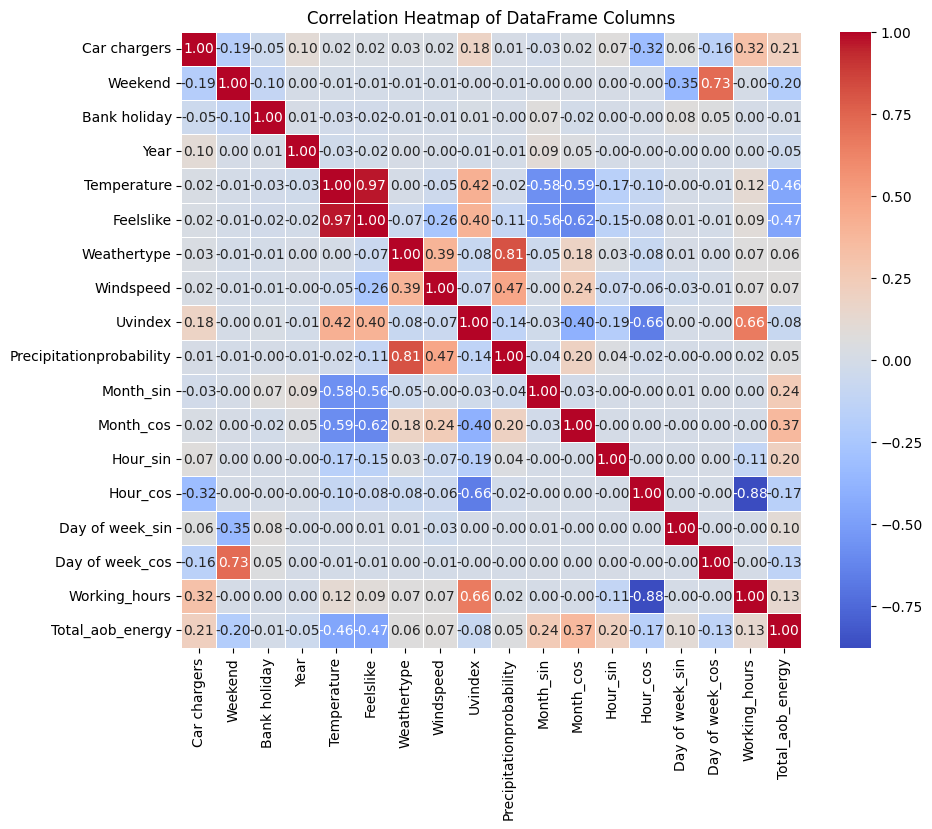

In [ ]:
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()

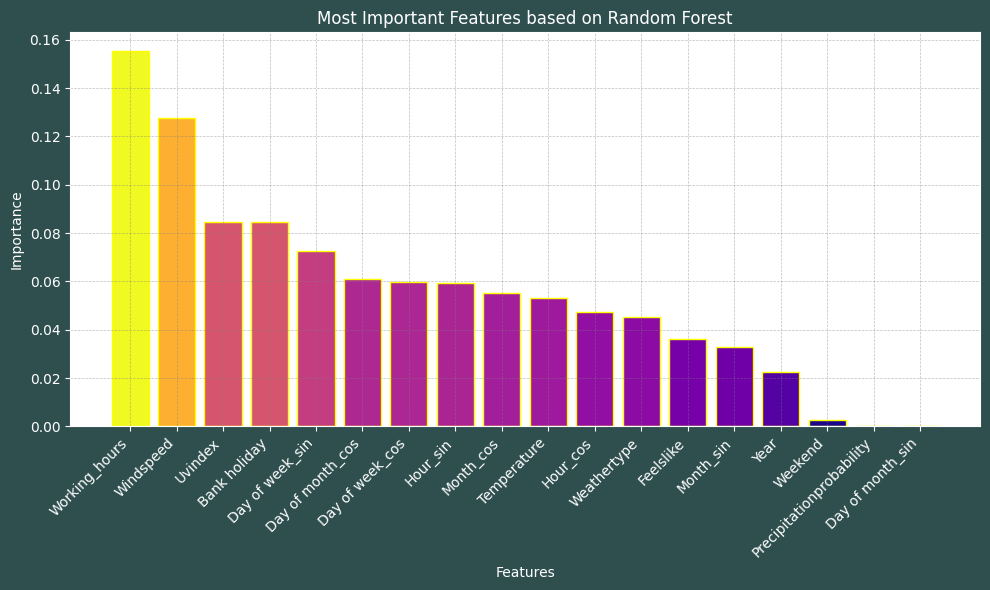

In [ ]:
# Split data into features and target
X = data_daily.drop(['Datepart','Car chargers'], axis=1)  # Assuming 'energy_consumption' is the target variable
y = data_daily['Car chargers']
# X = df[['hour_sin','hour_cos','Car Chargers','forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# X = df[['forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)
feature_names = X_train.columns
# Get feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order and select the top 10
indices = np.argsort(importances)
indices= indices[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

normalized_importances = importances[indices] / importances[indices].max()

# Generate a color for each importance score using the plasma colormap
colors = [plt.cm.plasma(i) for i in normalized_importances]

plt.figure(figsize=(10, 6), facecolor='darkslategray')
plt.title("Most Important Features based on Random Forest", color='white')

# Plot bars with the generated colors
for i, color in enumerate(colors):
    plt.bar(i, importances[indices][i], color=color, edgecolor='yellow')

# Assuming 'names' contains the feature names corresponding to 'indices'
plt.xticks(range(len(indices)), [names[i] for i in indices], rotation=45, ha='right', color='white')

plt.xlabel('Features', color='white')
plt.ylabel('Importance', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('white')

plt.tight_layout()
plt.show()

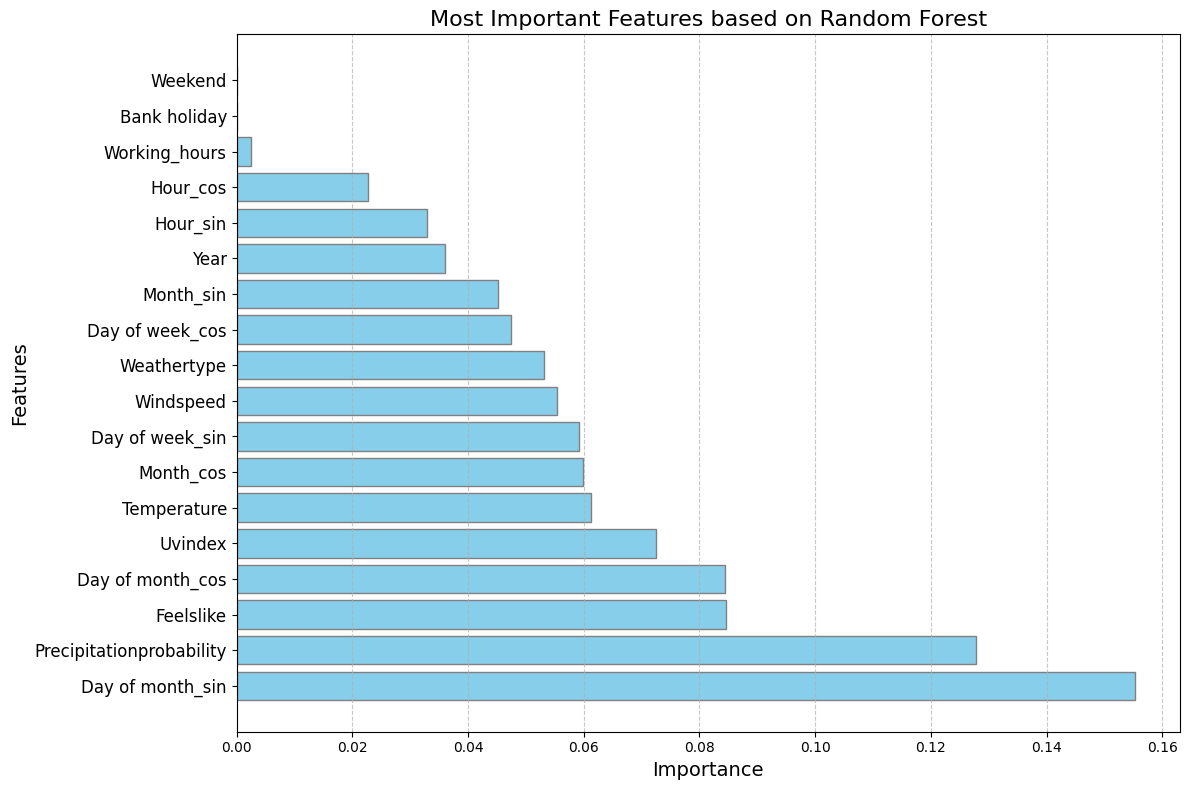

In [ ]:
# Create plot
plt.figure(figsize=(12, 8), facecolor='white')

# Create plot title
plt.title("Most Important Features based on Random Forest", fontsize=16)

# Add bars with color customization
plt.barh(range(len(indices)), importances[indices], color='skyblue', edgecolor='grey')

# Add feature names as y-axis labels
plt.yticks(range(len(indices)), names, fontsize=12)

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add labels and adjust alignment for better clarity
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Show plot
plt.tight_layout()
plt.show()

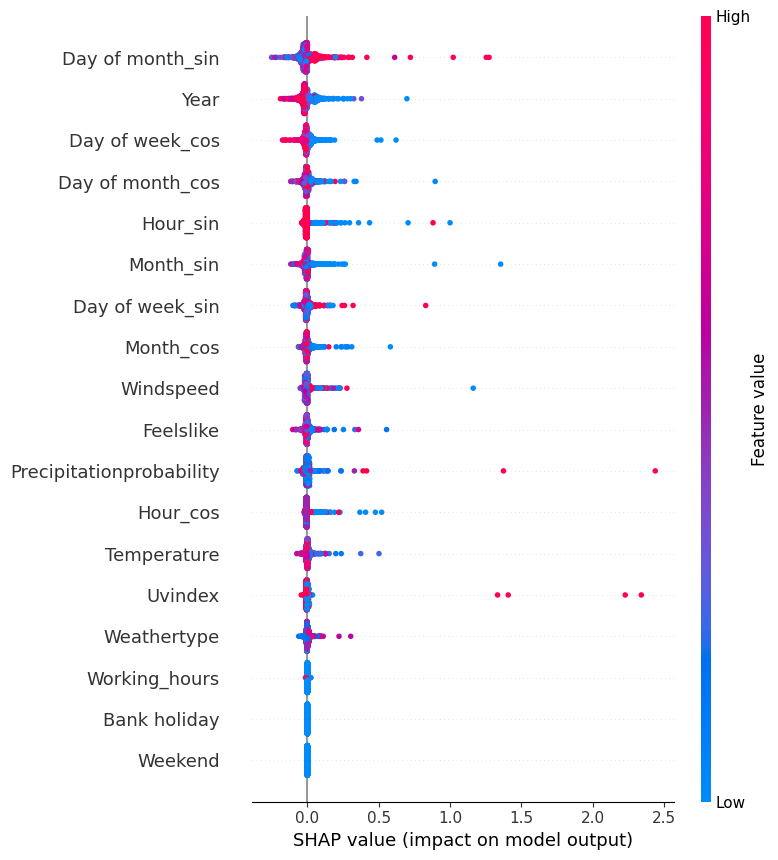

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [ ]:
print(importances) # note how importance of random forest adds to 1(total decision)

[0.00000000e+00 0.00000000e+00 9.71811201e-02 7.95553789e-02
 4.51963161e-01 2.20343751e-02 2.51767585e-02 2.00421308e-02
 3.43473387e-02 2.91870709e-02 6.21093373e-02 1.60845858e-03
 1.14277475e-03 5.21535933e-02 4.38405436e-02 3.82519225e-02
 4.11157482e-02 2.90287905e-04]


In [ ]:
df['time']

112     2019-04-05 16:00:00+00:00
113     2019-04-05 17:00:00+00:00
115     2019-04-05 19:00:00+00:00
116     2019-04-05 20:00:00+00:00
119     2019-04-05 23:00:00+00:00
                   ...           
41659   2023-12-31 19:00:00+00:00
41660   2023-12-31 20:00:00+00:00
41661   2023-12-31 21:00:00+00:00
41662   2023-12-31 22:00:00+00:00
41663   2023-12-31 23:00:00+00:00
Name: time, Length: 40766, dtype: datetime64[ns, UTC]

In [ ]:
df.dropna(inplace=True)

In [ ]:
print(df.dtypes)

datepart                             float64
year                                 float64
forecast_temperature                 float64
forecast_feelslike                   float64
forecast_weathertype                 float64
forecast_windspeed                   float64
forecast_uvindex                     float64
forecast_precipitationprobability    float64
month_sin                            float64
month_cos                            float64
hour_sin                             float64
hour_cos                             float64
day of week_sin                      float64
day of week_cos                      float64
day of month_sin                     float64
day of month_cos                     float64
total_aob_energy                     float64
dtype: object


In [ ]:

# Example DataFrame creation
data = {
    'date': ['2019-04-01 00:00:00+00', '2019-04-01 01:00:00+00', '2019-04-01 02:00:00+00',
             '2019-04-01 03:00:00+00', '2019-04-01 04:00:00+00'],
    'value': [1, 2, 3, 4, 5]  # Example values
}
# df['time']= dates
data = pd.DataFrame(df)

# Ensure 'date' column is datetime type
data['time'] = pd.to_datetime(data['time'])

# Set 'date' column as the DataFrame index
data.set_index('time', inplace=True)

# Verify the index is now a DatetimeIndex
print("Index type:", type(data.index))

# Now you can resample
data_daily = data.resample('D').mean()

print(data_daily)


Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
                           datepart    year  forecast_temperature  \
time                                                                
2019-04-06 00:00:00+00:00   43561.0  2019.0              8.000000   
2019-04-07 00:00:00+00:00   43562.0  2019.0             11.181818   
2019-04-08 00:00:00+00:00   43563.0  2019.0              9.791667   
2019-04-09 00:00:00+00:00   43564.0  2019.0              9.083333   
2019-04-10 00:00:00+00:00   43565.0  2019.0              8.000000   
...                             ...     ...                   ...   
2023-12-27 00:00:00+00:00   45287.0  2023.0             10.750000   
2023-12-28 00:00:00+00:00   45288.0  2023.0              8.750000   
2023-12-29 00:00:00+00:00   45289.0  2023.0              9.375000   
2023-12-30 00:00:00+00:00   45290.0  2023.0              9.000000   
2023-12-31 00:00:00+00:00   45291.0  2023.0              8.875000   

                           forecast_

In [ ]:
# data_daily.index = data_daily.index.date

# Now your DataFrame's index should be in the 'YYYY-MM-DD' format without the time component
# data_daily.info()
data_daily.dropna(inplace=True)

In [ ]:
data_daily

datepart    year  forecast_temperature  forecast_feelslike  \
2019-04-06   43561.0  2019.0              8.000000            5.500000   
2019-04-07   43562.0  2019.0             11.181818            9.545455   
2019-04-08   43563.0  2019.0              9.791667            8.291667   
2019-04-09   43564.0  2019.0              9.083333            6.750000   
2019-04-10   43565.0  2019.0              8.000000            5.291667   
...              ...     ...                   ...                 ...   
2023-12-27   45287.0  2023.0             10.750000            6.000000   
2023-12-28   45288.0  2023.0              8.750000            5.000000   
2023-12-29   45289.0  2023.0              9.375000            5.833333   
2023-12-30   45290.0  2023.0              9.000000            4.166667   
2023-12-31   45291.0  2023.0              8.875000            5.250000   

            forecast_weathertype  forecast_windspeed  forecast_uvindex  \
2019-04-06              7.000000           11.500000          0.250000   
2019-04-07              4.181818            9.909091          1.545455   
2019-04-08              8.708333            8.583333          0.750000   
2019-04-09              2.208333           10.166667          1.458333   
2019-04-10              0.625000           11.625000          1.458333   
...                          ...                 ...               ...   
2023-12-27             11.708333           33.125000          0.375000   
2023-12-28              9.041667           20.791667          0.375000   
2023-12-29             11.000000           20.458333          0.375000   
2023-12-30             12.458333           29.250000          0.375000   
2023-12-31             10.166667           21.708333          0.375000   

            forecast_precipitationprobability     month_sin  month_cos  \
2019-04-06                           3.250000  8.660254e-01       -0.5   
2019-04-07                           4.272727  8.660254e-01       -0.5   
2019-04-08                          28.000000  8.660254e-01       -0.5   
2019-04-09                           3.708333  8.660254e-01       -0.5   
2019-04-10                           0.000000  8.660254e-01       -0.5   
...                                       ...           ...        ...   
2023-12-27                          52.833333 -2.449294e-16        1.0   
2023-12-28                          38.125000 -2.449294e-16        1.0   
2023-12-29                          48.250000 -2.449294e-16        1.0   
2023-12-30                          65.916667 -2.449294e-16        1.0   
2023-12-31                          52.166667 -2.449294e-16        1.0   

                hour_sin      hour_cos  day of week_sin  day of week_cos  \
2019-04-06  4.311862e-01  6.432830e-01        -0.781831         0.623490   
2019-04-07 -4.785275e-01 -5.680404e-02         0.000000         1.000000   
2019-04-08 -1.619075e-17 -5.088522e-17         0.781831         0.623490   
2019-04-09 -1.619075e-17 -5.088522e-17         0.974928        -0.222521   
2019-04-10 -1.619075e-17 -5.088522e-17         0.433884        -0.900969   
...                  ...           ...              ...              ...   
2023-12-27 -1.619075e-17 -5.088522e-17         0.433884        -0.900969   
2023-12-28 -1.619075e-17 -5.088522e-17        -0.433884        -0.900969   
2023-12-29 -1.619075e-17 -5.088522e-17        -0.974928        -0.222521   
2023-12-30 -1.619075e-17 -5.088522e-17        -0.781831         0.623490   
2023-12-31 -1.619075e-17 -5.088522e-17         0.000000         1.000000   

            day of month_sin  day of month_cos  total_aob_energy  
2019-04-06      9.377521e-01          0.347305          1.780730  
2019-04-07      9.884683e-01          0.151428          1.557236  
2019-04-08      9.987165e-01         -0.050649          3.403896  
2019-04-09      9.680771e-01         -0.250653          3.486373  
2019-04-10      8.978045e-01         -0.440394          3.696560  
...                      ...  

In [ ]:
dates = data_daily

In [ ]:
# Split data into features and target
X = data_daily.drop(['datepart','total_aob_energy'], axis=1)  # Assuming 'energy_consumption' is the target variable
y = data_daily['total_aob_energy']
# X = df[['hour_sin','hour_cos','Car Chargers','forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# X = df[['forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Model Training
# Linear Regression
# lr_model = LinearRegression()
# lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Calculate range of the target variable
y_range = np.max(y_test) - np.min(y_test)
# Calculate the mean of the target variable
y_mean = np.mean(y_test)
# Calculate RMSE for Linear Regression
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# Calculate Normalised RMSE for Linear Regression
rf_nrmse = rf_rmse / y_range
# Calculate rRMSE (relative RMSE) for Linear Regression, normalized by the mean of y_test
rf_rrmse = rf_rmse / y_mean
# Calculate MAE
rf_mae = np.mean(np.abs(y_test - y_pred_rf))
print("Mean Absolute Error (MAE) for Linear Regression:", rf_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
rf_mape = np.mean(np.abs((y_test - y_pred_rf) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Linear Regression:", rf_mape, "%")

print("Linear Regression RMSE:", rf_rmse)
print("Linear Regression NRMSE:", rf_nrmse)
print("Linear Regression rRMSE:", rf_rrmse)




Mean Absolute Error (MAE) for Linear Regression: 0.3115618277536241
Mean Absolute Percentage Error (MAPE) for Linear Regression: 19.42940625096584 %
Linear Regression RMSE: 0.4181778911685568
Linear Regression NRMSE: 0.09679250350843431
Linear Regression rRMSE: 0.24442389442781332


In [ ]:
# Set 'date' column as the DataFrame index
# df.set_index('time', inplace=True)

# # Verify the index is now a DatetimeIndex
# print("Index type:", type(df.index))

# Now you can resample
# data_daily = df.resample('D').mean()

print(data_daily)

# Split data into features and target
X = data_daily.drop(['datepart','total_aob_energy'], axis=1)  # Assuming 'energy_consumption' is the target variable
y = data_daily['total_aob_energy']
# X = df[['hour_sin','hour_cos','Car Chargers','forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# X = df[['forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_test,y_test)
y_pred_rf_train = rf_model.predict(X_test)


                           datepart    year  forecast_temperature  \
time                                                                
2019-04-05 00:00:00+00:00   43560.0  2019.0             12.000000   
2019-04-06 00:00:00+00:00   43561.0  2019.0              8.285714   
2019-04-07 00:00:00+00:00   43562.0  2019.0             11.181818   
2019-04-08 00:00:00+00:00   43563.0  2019.0              9.791667   
2019-04-09 00:00:00+00:00   43564.0  2019.0              9.083333   
...                             ...     ...                   ...   
2023-12-27 00:00:00+00:00   45287.0  2023.0             10.750000   
2023-12-28 00:00:00+00:00   45288.0  2023.0              8.750000   
2023-12-29 00:00:00+00:00   45289.0  2023.0              9.375000   
2023-12-30 00:00:00+00:00   45290.0  2023.0              9.000000   
2023-12-31 00:00:00+00:00   45291.0  2023.0              8.875000   

                           forecast_feelslike  forecast_weathertype  \
time                           

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40766 entries, 2019-04-05 16:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   datepart                           40766 non-null  float64
 1   year                               40766 non-null  float64
 2   forecast_temperature               40766 non-null  float64
 3   forecast_feelslike                 40766 non-null  float64
 4   forecast_weathertype               40766 non-null  float64
 5   forecast_windspeed                 40766 non-null  float64
 6   forecast_uvindex                   40766 non-null  float64
 7   forecast_precipitationprobability  40766 non-null  float64
 8   month_sin                          40766 non-null  float64
 9   month_cos                          40766 non-null  float64
 10  hour_sin                           40766 non-null  float64
 11  hour_co

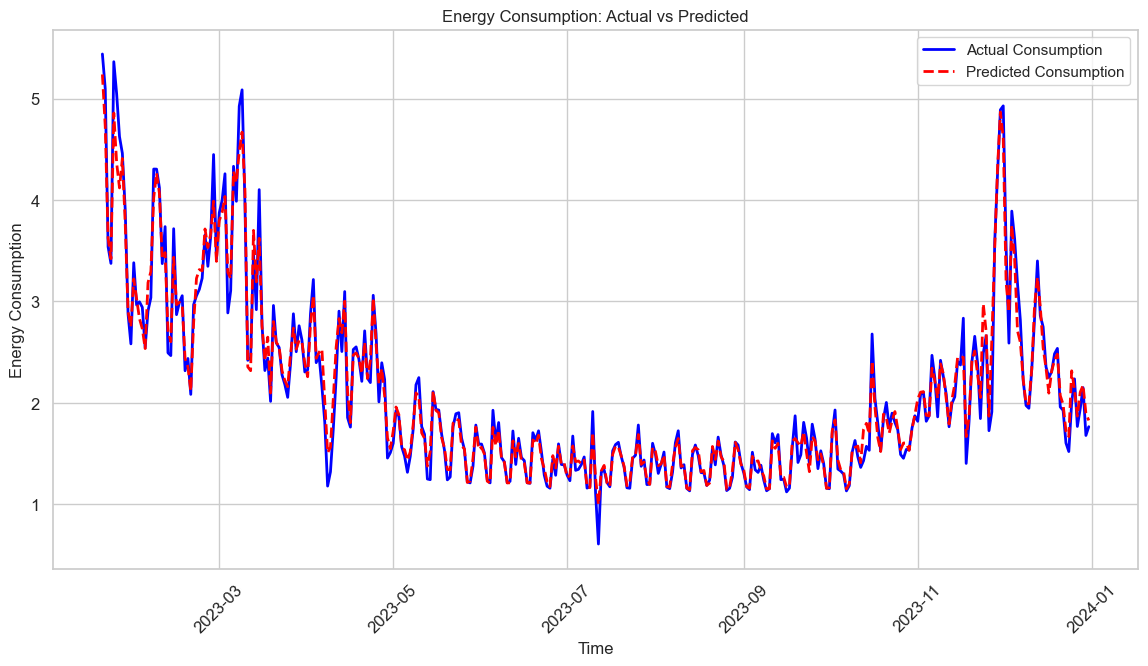

In [ ]:
df_error = pd.DataFrame({
    'Actual Consumption': y_test,
    'Predicted Consumption': y_pred_rf_train
}, index=y_test.index)  # Use 'dates' as the index

# Ensure the DataFrame is sorted by date
df_error.sort_index(inplace=True)

# Plotting
sns.set_theme(style="whitegrid")  # This sets a nice background grid and improves overall aesthetics

plt.figure(figsize=(14, 7))
plt.plot(df_error.index, df_error['Actual Consumption'], label='Actual Consumption', color='blue', linewidth=2)
plt.plot(df_error.index, df_error['Predicted Consumption'], label='Predicted Consumption', color='red', linestyle='--', linewidth=2)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()

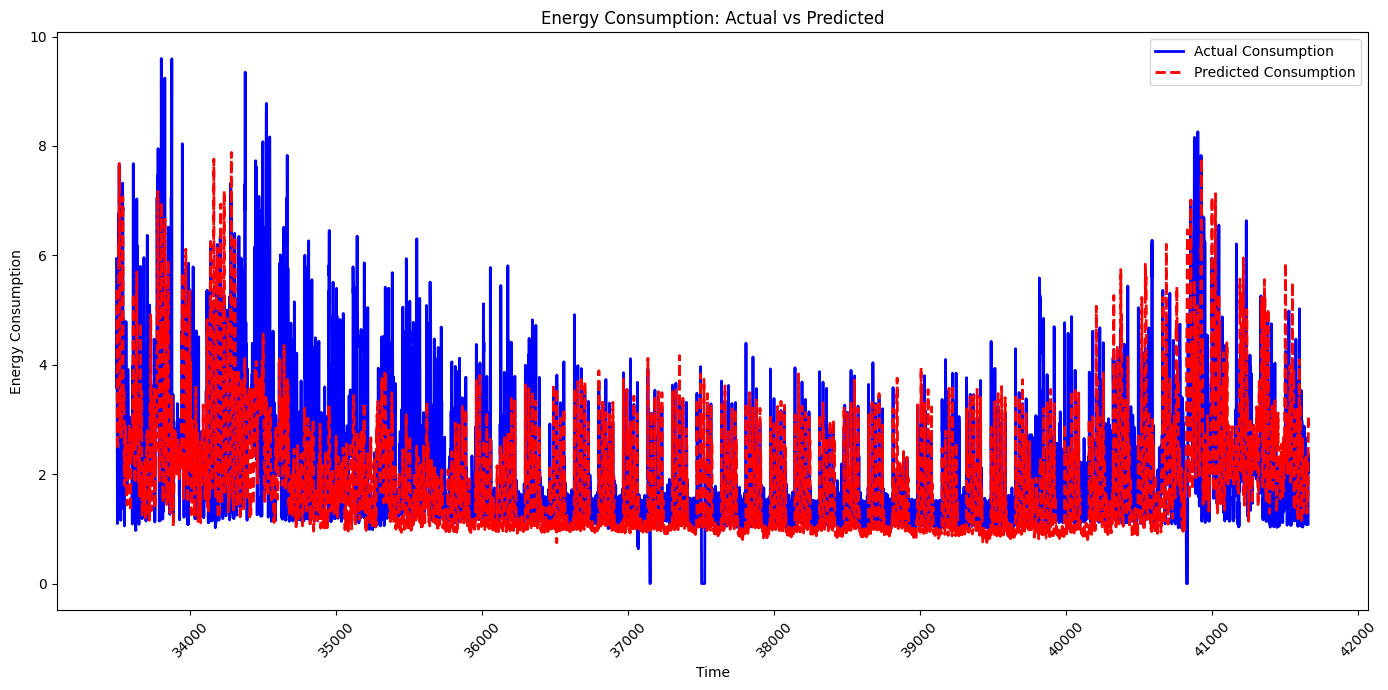

In [ ]:
# dates = pd.to_datetime(dates)

# Create a DataFrame for easier plotting
df_error = pd.DataFrame({
    'Actual Consumption': y_test,
    'Predicted Consumption': y_pred_rf
})

# Sort the DataFrame by date if it's not already sorted

# Plotting
sns.set_theme(style="whitegrid")  # This sets a nice background grid and improves overall aesthetics

plt.figure(figsize=(14, 7))
plt.plot( df['Actual Consumption'], label='Actual Consumption', color='blue', linewidth=2)
plt.plot( df['Predicted Consumption'], label='Predicted Consumption', color='red', linestyle='--', linewidth=2)

plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Optionally, you can limit the displayed range to a specific period for a clearer view
# plt.xlim([pd.Timestamp('YYYY-MM-DD'), pd.Timestamp('YYYY-MM-DD')])

plt.tight_layout()  # Adjust the layout to make room for the rotated date labels
plt.show()

In [ ]:
y_test

2023-05-28    1.209702
2023-05-29    1.374067
2023-05-30    1.779897
2023-05-31    1.592341
2023-06-01    1.592352
                ...   
2023-12-27    1.766175
2023-12-28    1.938858
2023-12-29    2.149062
2023-12-30    1.677269
2023-12-31    1.763823
Name: total_aob_energy, Length: 218, dtype: float64

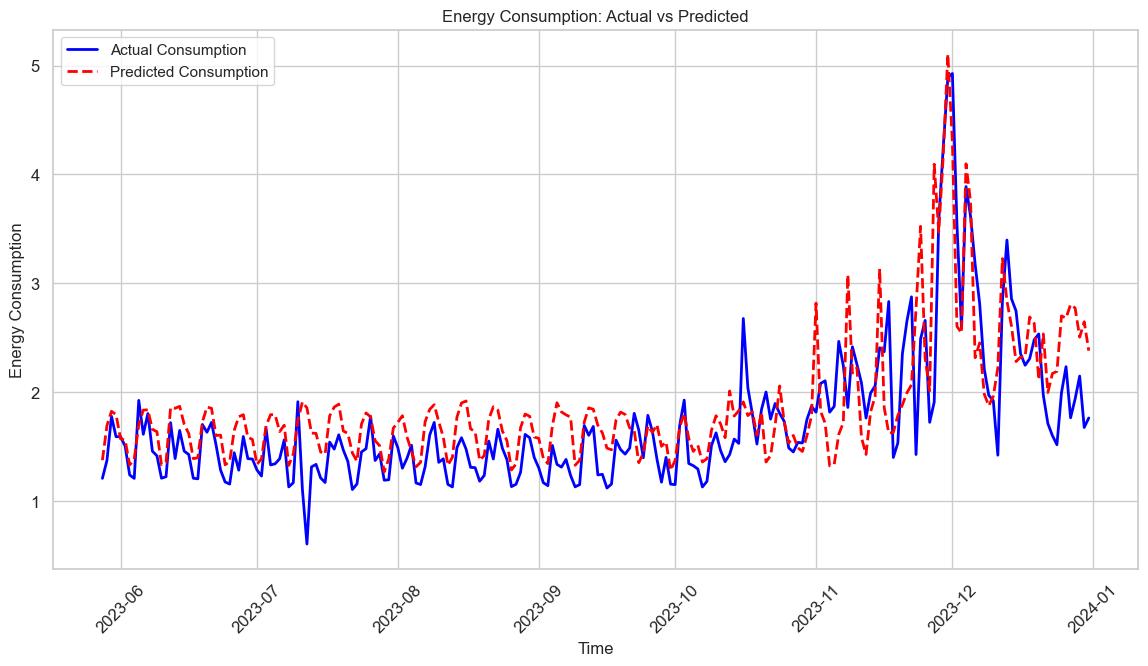

In [ ]:
df_error = pd.DataFrame({
    'Actual Consumption': y_test,
    'Predicted Consumption': y_pred_rf
}, index=y_test.index)  # Use 'dates' as the index

# Ensure the DataFrame is sorted by date
df_error.sort_index(inplace=True)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df_error.index, df_error['Actual Consumption'], label='Actual Consumption', color='blue', linewidth=2)
plt.plot(df_error.index, df_error['Predicted Consumption'], label='Predicted Consumption', color='red', linestyle='--', linewidth=2)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()

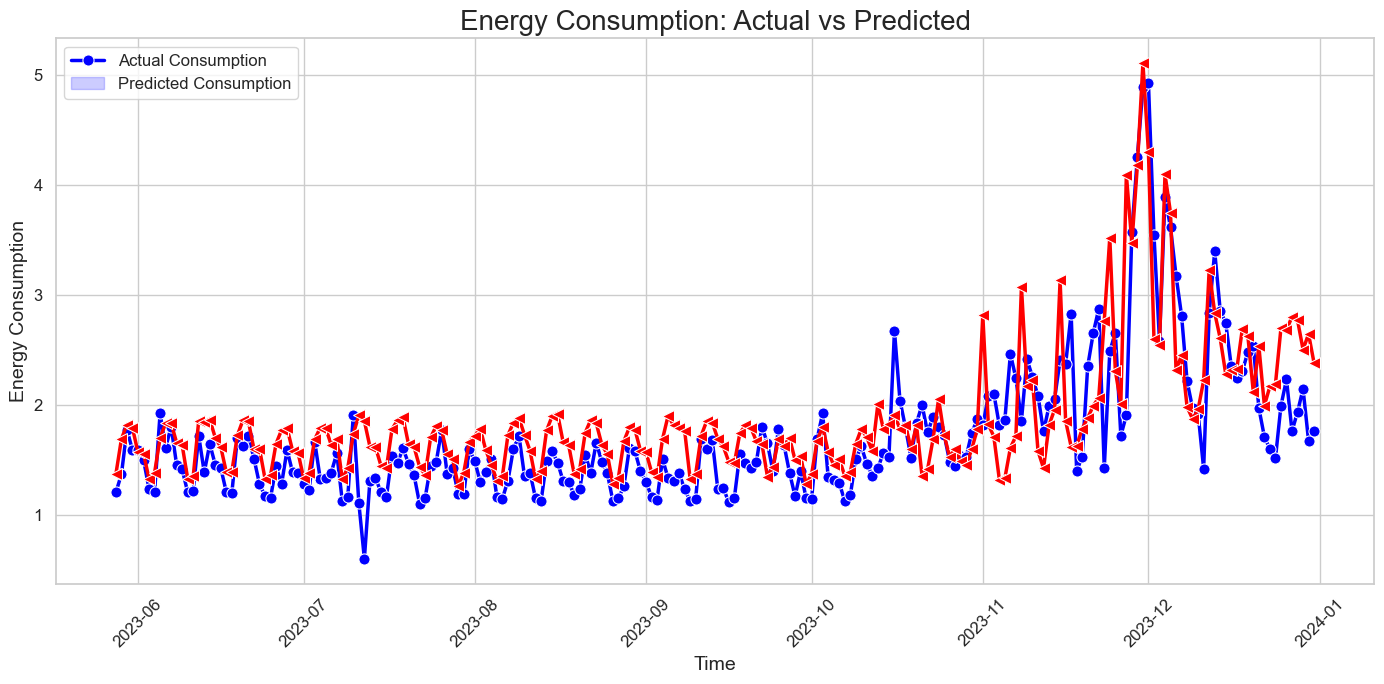

In [ ]:
sns.set(style="whitegrid")  # This sets a nice background grid and improves overall aesthetics

# Plotting with Seaborn's lineplot function for automatic handling of datetime x-axis and improved aesthetics
plt.figure(figsize=(14, 7))

sns.lineplot(data=df_error, palette=['blue', 'red'], linewidth=2.5, dashes=False, markers=["o", "<"], markersize=8)

plt.title('Energy Consumption: Actual vs Predicted', fontsize=20)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend(labels=['Actual Consumption', 'Predicted Consumption'], fontsize=12)

# Improve readability of the x-axis labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adjust the layout
plt.tight_layout()

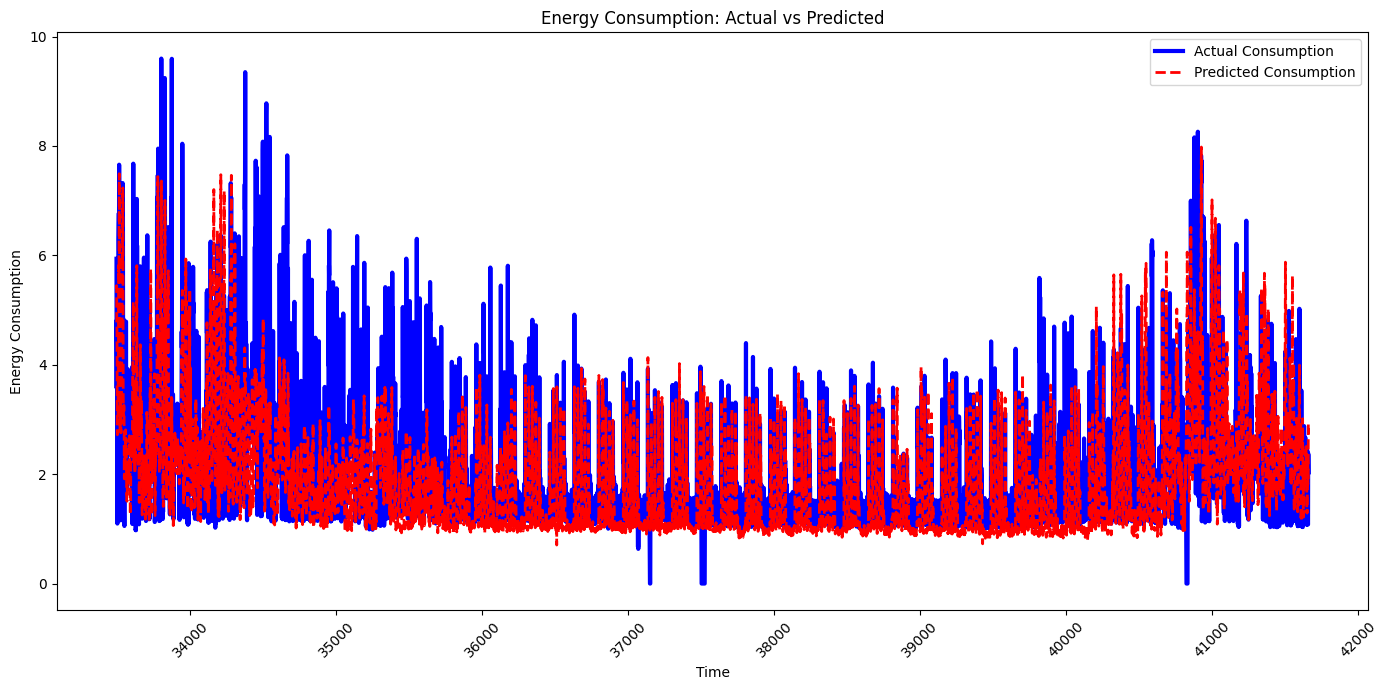

In [ ]:
dates = dates[-8154:]
# dates = pd.to_datetime(dates)
# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Actual Consumption': y_test,
    'Predicted Consumption': y_pred_rf
})

# Sort the DataFrame by date if it's not already sorted
# df = df.sort_index()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['Actual Consumption'], label='Actual Consumption', color='blue', linewidth=3)
plt.plot(df['Predicted Consumption'], label='Predicted Consumption', color='red', linestyle='--', linewidth=2)

plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Optionally, you can limit the displayed range to a specific period for a clearer view
# plt.xlim([pd.Timestamp('YYYY-MM-DD'), pd.Timestamp('YYYY-MM-DD')])

plt.tight_layout()  # Adjust the layout to make room for the rotated date labels
plt.show()

In [ ]:

# Get the current date and time
current_timestamp = datetime.now()

# Format the timestamp without seconds
formatted_timestamp = current_timestamp.strftime('%Y-%m-%d %H:%M')

print("Formatted Timestamp:", formatted_timestamp)

Formatted Timestamp: 2024-03-21 05:47


In [ ]:
# Assuming y_test, y_pred_lr, y_pred_rf, y_pred_gbr, y_pred_ridge, y_pred_lasso, y_pred_svr are defined
# Define a dictionary to hold the results
results = {
    "Method": [],
    "RMSE": [],
    "NRMSE": [],
    "rRMSE": [],
    "MAE": [],
    "MAPE": []
}

methods = ["Linear Regression", "Random Forest", "Gradient Boosting Regression", "Ridge", "Lasso", "SVR"]
predictions = [y_pred_lr, y_pred_rf, y_pred_gbr, y_pred_ridge, y_pred_lasso, y_pred_svr]

y_range = np.max(y_test) - np.min(y_test)
y_mean = np.mean(y_test)
i = 0
for method, y_pred in zip(methods, predictions):
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # Calculate NRMSE
    nrmse = rmse / y_range
    # Calculate rRMSE
    rrmse = rmse / y_mean
    # Calculate MAE
    mae = np.mean(np.abs(y_test - y_pred))
    # Calculate MAPE
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100

    # Append the results
    results["Method"].append(method)
    results["RMSE"].append(rmse)
    results["NRMSE"].append(nrmse)
    results["rRMSE"].append(rrmse)
    results["MAE"].append(mae)
    results["MAPE"].append(mape)

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results)
name = f"regression_metrics_AOBresults{formatted_timestamp}.csv"

try:
    results_df.to_csv(name, index=False)
    print("Results saved to", name)
except Exception as e:
    print("Error saving the file:", e)
# Save the DataFrame to a CSV file
# results_df.to_csv(name)

# print("Results saved to ",name)

Results saved to regression_metrics_AOBresults2024-03-21 05:47.csv


In [ ]:
import os
print(os.getcwd())

c:\AOB\AOB_Energy_Consumption_Analysis_Prediction


In [ ]:
results_df.head()
results_df.to_csv("regression_metrics_AOBresults2024-03-21 22", index=False)

In [ ]:
display(df)

time  datepart    year  forecast_temperature  \
120   2019-04-06 00:00:00+00:00   43561.0  2019.0                   8.0   
121   2019-04-06 01:00:00+00:00   43561.0  2019.0                   8.0   
122   2019-04-06 02:00:00+00:00   43561.0  2019.0                   8.0   
127   2019-04-06 07:00:00+00:00   43561.0  2019.0                   8.0   
154   2019-04-07 10:00:00+00:00   43562.0  2019.0                  10.0   
...                         ...       ...     ...                   ...   
41659 2023-12-31 19:00:00+00:00   45291.0  2023.0                  10.0   
41660 2023-12-31 20:00:00+00:00   45291.0  2023.0                  10.0   
41661 2023-12-31 21:00:00+00:00   45291.0  2023.0                  11.0   
41662 2023-12-31 22:00:00+00:00   45291.0  2023.0                  11.0   
41663 2023-12-31 23:00:00+00:00   45291.0  2023.0                  11.0   

       forecast_feelslike  forecast_weathertype  forecast_windspeed  \
120                   6.0                   7.0                11.0   
121                   6.0                   7.0                11.0   
122                   6.0                   7.0                11.0   
127                   4.0                   7.0                13.0   
154                   8.0                   7.0                11.0   
...                   ...                   ...                 ...   
41659                 6.0                  15.0                22.0   
41660                 6.0                  15.0                22.0   
41661                 7.0                  15.0                34.0   
41662                 7.0                  15.0                34.0   
41663                 7.0                  15.0                34.0   

       forecast_uvindex  forecast_precipitationprobability     month_sin  \
120                 0.0                                3.0  8.660254e-01   
121                 0.0                                3.0  8.660254e-01   
122                 0.0                                3.0  8.660254e-01   
127                 1.0                                4.0  8.660254e-01   
154                 2.0                                9.0  8.660254e-01   
...                 ...                                ...           ...   
41659               0.0                               96.0 -2.449294e-16   
41660               0.0                               97.0 -2.449294e-16   
41661               0.0                               96.0 -2.449294e-16   
41662               0.0                               96.0 -2.449294e-16   
41663               0.0                               96.0 -2.449294e-16   

       month_cos  hour_sin  hour_cos  day of week_sin  day of week_cos  \
120         -0.5  0.000000  1.000000        -0.781831          0.62349   
121         -0.5  0.258819  0.965926        -0.781831          0.62349   
122         -0.5  0.500000  0.866025        -0.781831          0.62349   
127         -0.5  0.965926 -0.258819        -0.781831          0.62349   
154         -0.5  0.500000 -0.866025         0.000000          1.00000   
...          ...       ...       ...              ...              ...   
41659        1.0 -0.965926  0.258819         0.000000          1.00000   
41660        1.0 -0.866025  0.500000         0.000000          1.00000   
41661        1.0 -0.707107  0.707107         0.000000          1.00000   
41662        1.0 -0.500000  0.866025         0.000000          1.00000   
41663        1.0 -0.258819  0.965926         0.000000          1.00000   

       day of month_sin  day of month_cos  total_aob_energy  
120        9.377521e-01          0.347305          1.822014  
121        9.377521e-01          0.347305          1.794794  
122        9.377521e-01          0.347305          1.757064  
127        9.377521e-01          0.347305          1.749047  
154        9.884683e-01          0.151428          1.748828  
...                 ...               ...               ...  
41659     -2.449294e-16          1.00

In [ ]:
data_daily

NameError: name 'data_daily' is not defined

C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_41744\2759908011.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast['Energy Level'] = energy_bins


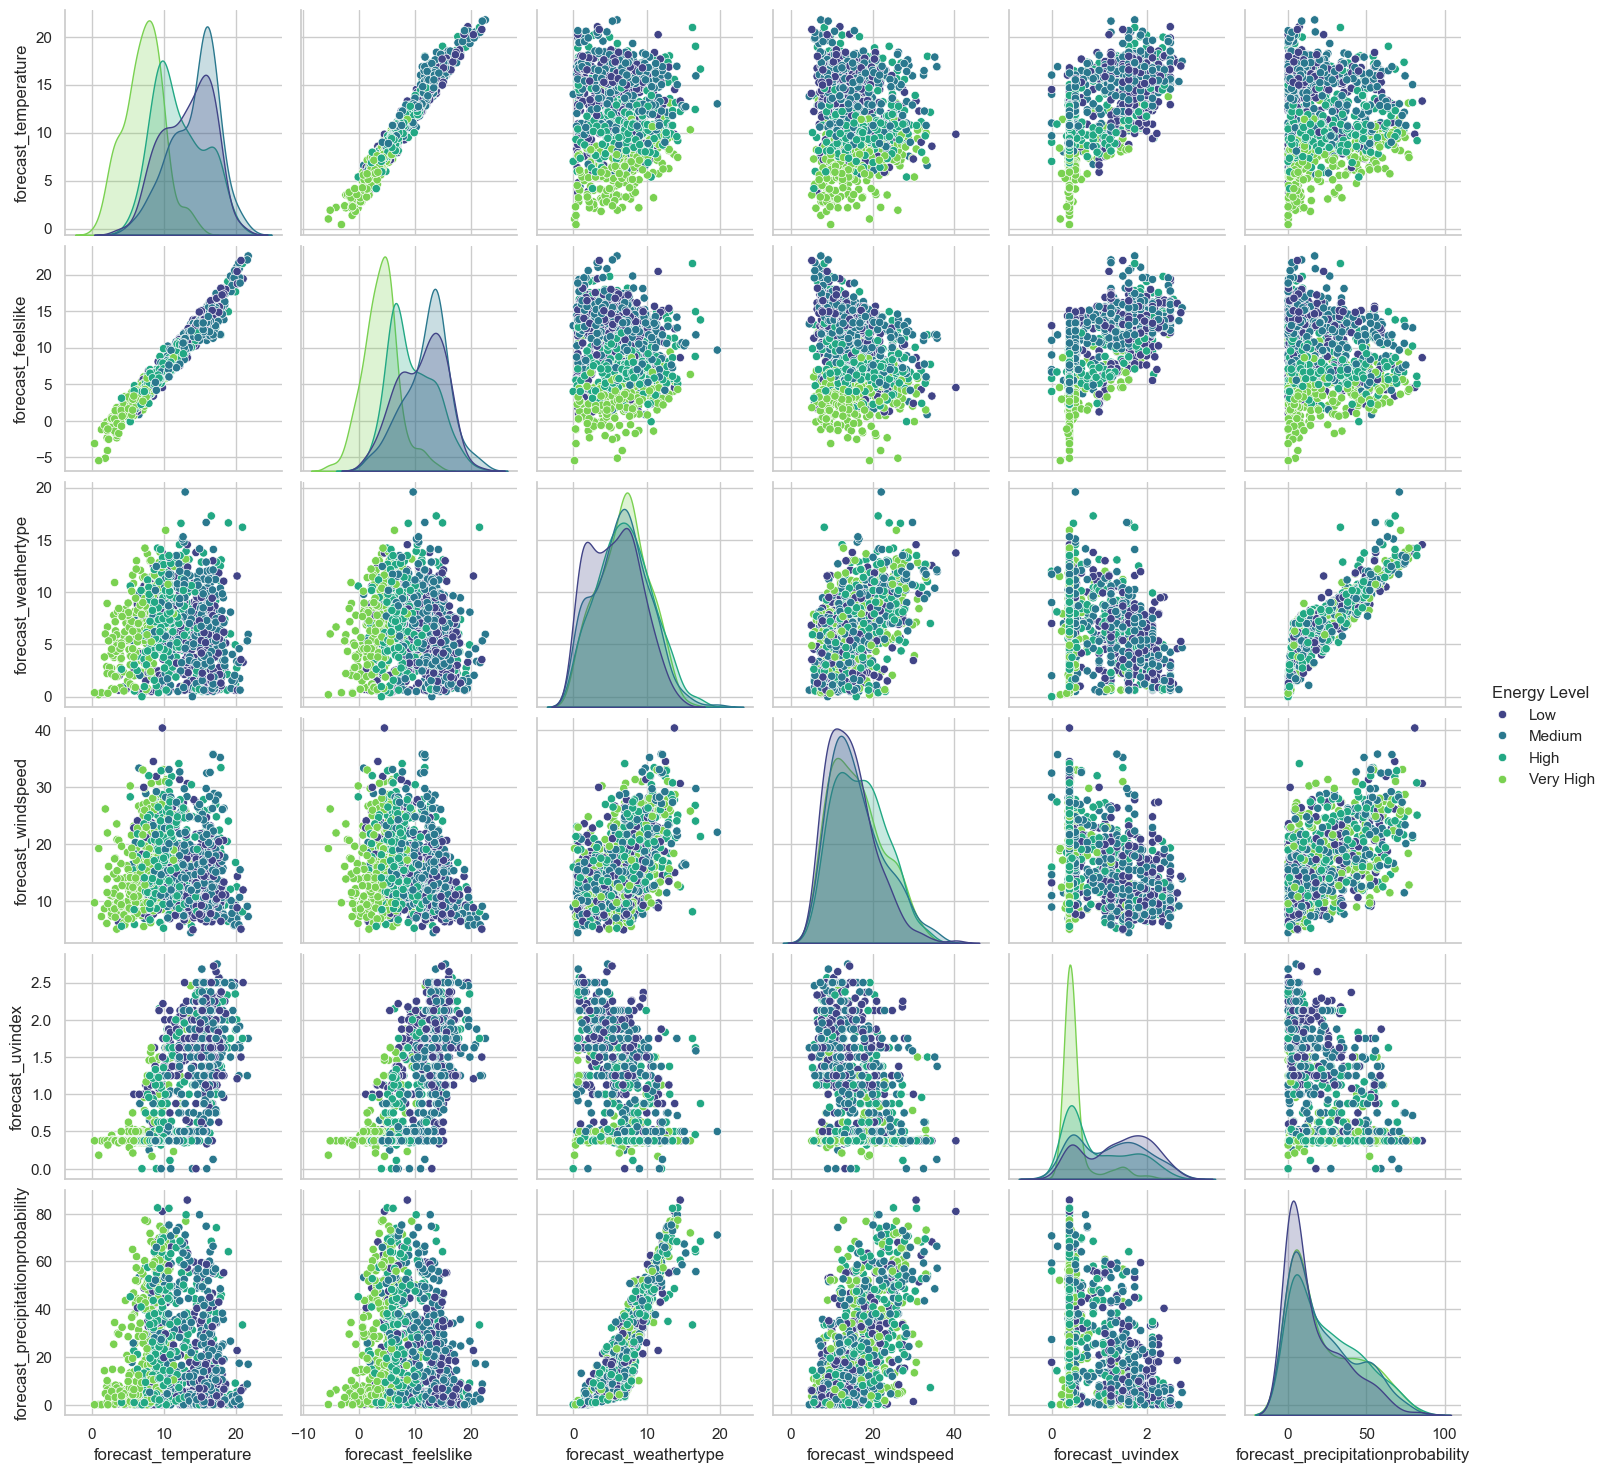

In [ ]:
# Generate a list of columns to drop
forecast_columns = [col for col in data_daily.columns if col.startswith('forecast')]
# display(forecast_columns)
energy_bins = pd.qcut(data_daily['total_aob_energy'], q=4, labels=["Low", "Medium", "High", "Very High"])
# Drop these columns from the DataFrame
# df = df.drop(columns=columns_to_drop)
df_forecast = data_daily[forecast_columns]

df_forecast['Energy Level'] = energy_bins

# Plot using pairplot with the new 'Energy Level' column as hue
sns.pairplot(df_forecast, hue='Energy Level', palette="viridis")

In [ ]:
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1087 entries, 2019-04-06 to 2023-12-31
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   forecast_temperature               1087 non-null   float64 
 1   forecast_feelslike                 1087 non-null   float64 
 2   forecast_weathertype               1087 non-null   float64 
 3   forecast_windspeed                 1087 non-null   float64 
 4   forecast_uvindex                   1087 non-null   float64 
 5   forecast_precipitationprobability  1087 non-null   float64 
 6   Energy Level                       1087 non-null   category
dtypes: category(1), float64(6)
memory usage: 93.0+ KB


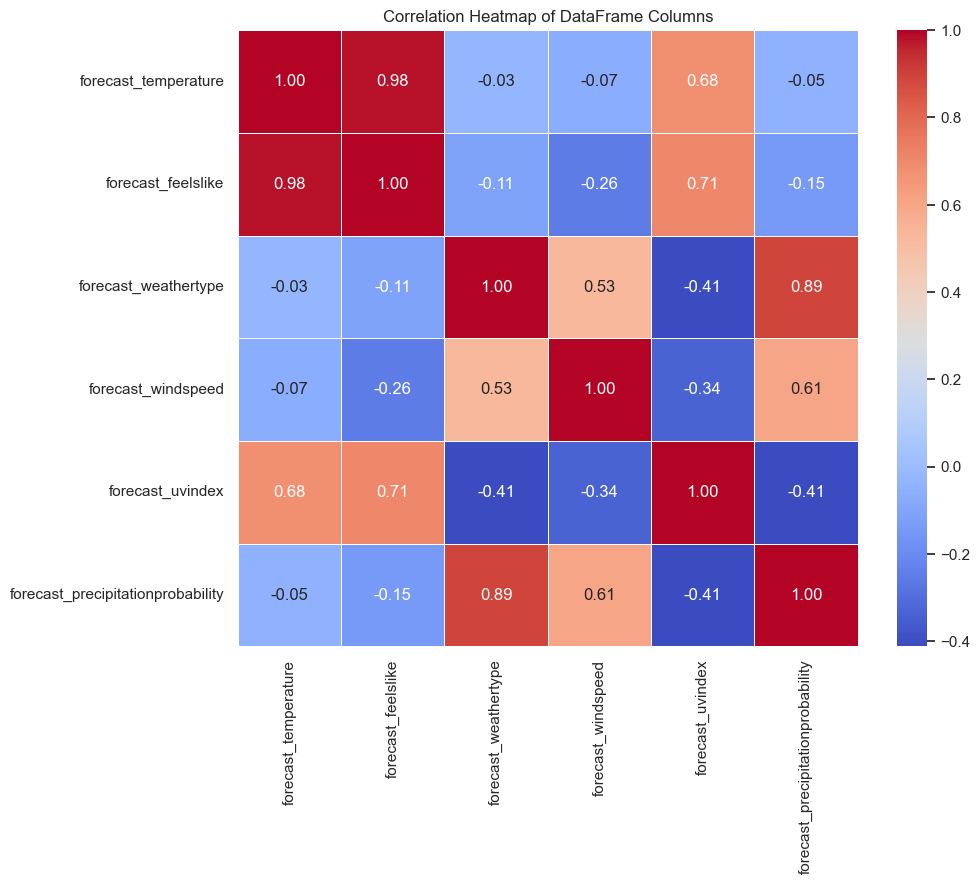

In [ ]:

df_forecast = df_forecast.drop(['Energy Level'], axis = 1 )

# Calculate the correlation matrix
correlation_matrix = df_forecast.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()

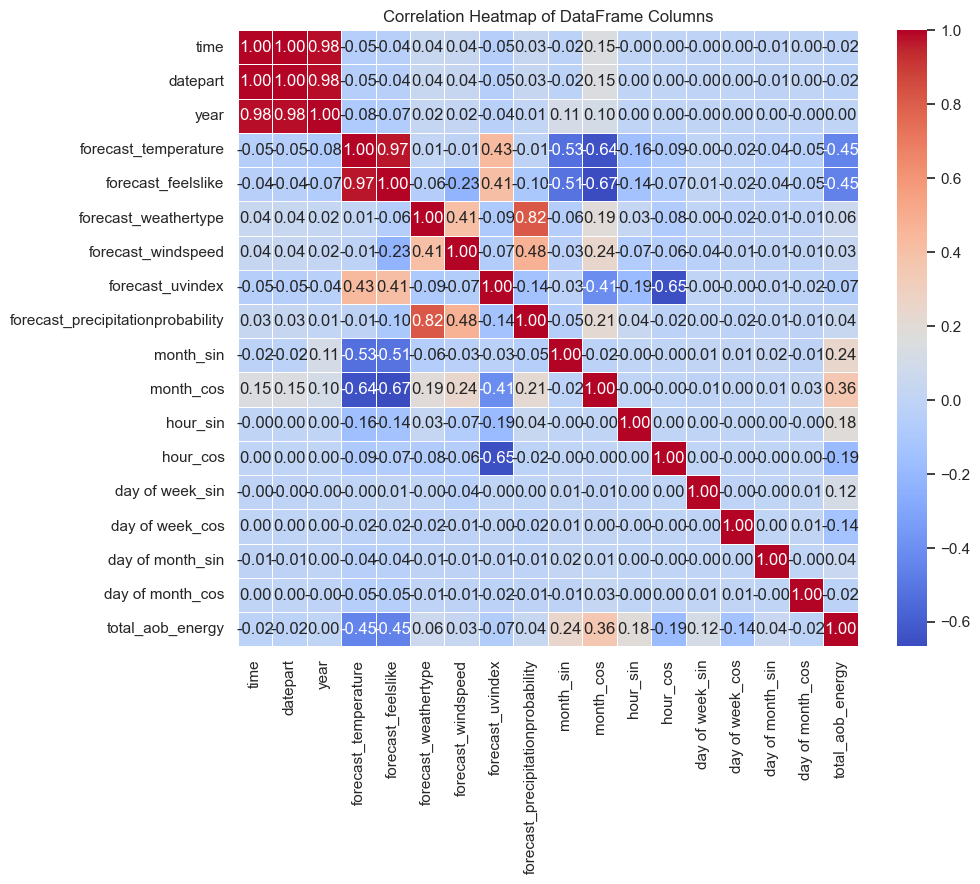

In [ ]:


# Calculate the correlation matrix
correlation_matrix0 = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix0, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25293 entries, 120 to 41663
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   time                               25293 non-null  datetime64[ns, UTC]
 1   datepart                           25293 non-null  float64            
 2   year                               25293 non-null  float64            
 3   forecast_temperature               25293 non-null  float64            
 4   forecast_feelslike                 25293 non-null  float64            
 5   forecast_weathertype               25293 non-null  float64            
 6   forecast_windspeed                 25293 non-null  float64            
 7   forecast_uvindex                   25293 non-null  float64            
 8   forecast_precipitationprobability  25293 non-null  float64            
 9   month_sin                          25293 non-null  fl

In [ ]:
df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
df.dropna(inplace=True)
df = df.select_dtypes(exclude=['object'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24801 entries, 120 to 41663
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Comms and Services                 24801 non-null  float64
 1   Car Chargers                       24801 non-null  float64
 2   Space Heating                      24801 non-null  float64
 3   Hot Water                          24801 non-null  float64
 4   Sockets                            24801 non-null  float64
 5   Lighting                           24801 non-null  float64
 6   datepart                           24801 non-null  float64
 7   hour                               24801 non-null  float64
 8   day of week                        24801 non-null  float64
 9   day of month                       24801 non-null  float64
 10  month                              24801 non-null  float64
 11  year                               24801 non-null  float6

C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_41744\1235424168.py:1: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"


In [ ]:
columns_to_drop = [col for col in df.columns if col.startswith('forecast')]

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24801 entries, 120 to 41663
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Comms and Services       24801 non-null  float64
 1   Car Chargers             24801 non-null  float64
 2   Space Heating            24801 non-null  float64
 3   Hot Water                24801 non-null  float64
 4   Sockets                  24801 non-null  float64
 5   Lighting                 24801 non-null  float64
 6   datepart                 24801 non-null  float64
 7   hour                     24801 non-null  float64
 8   day of week              24801 non-null  float64
 9   day of month             24801 non-null  float64
 10  month                    24801 non-null  float64
 11  year                     24801 non-null  float64
 12  observation_temperature  24801 non-null  float64
 13  observation_windspeed    24801 non-null  float64
 14  observation_pressure     

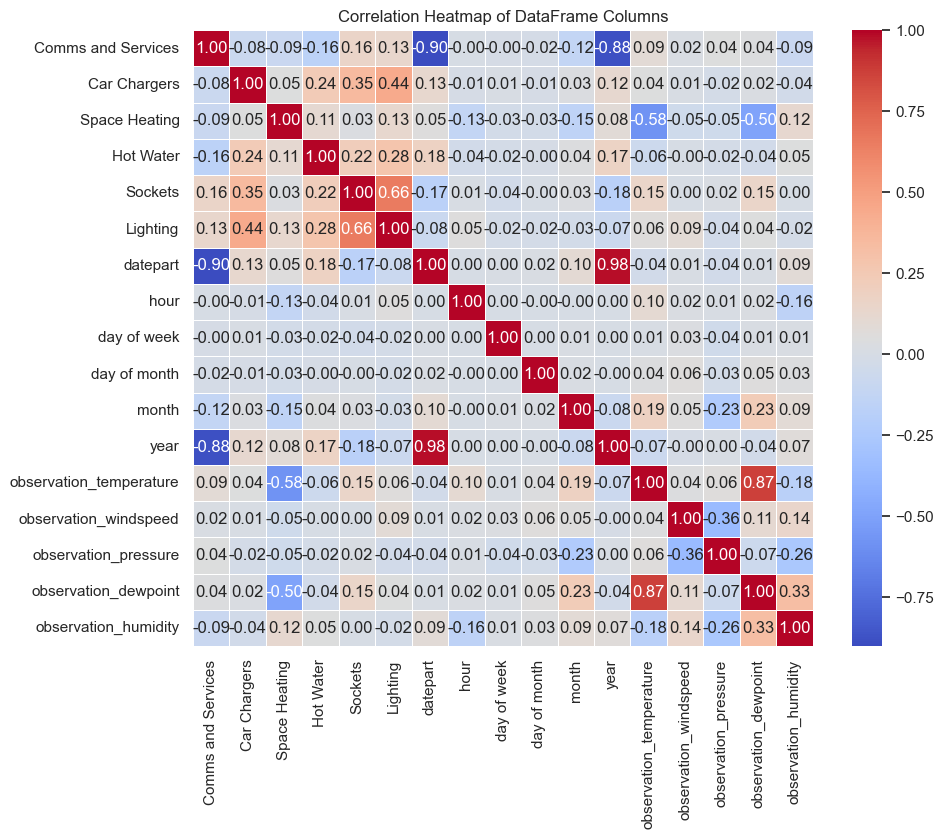

In [ ]:

# Calculate the correlation matrix
correlation_matrix0 = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix0, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()

In [ ]:
df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
columns_to_drop = [col for col in df.columns if col.startswith('observation')]
df = df.drop(columns=columns_to_drop)
df.dropna(inplace=True)

# Sum specified columns to create 'total_aob_energy'
df['total_aob_energy'] = df[['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting']].sum(axis=1, skipna=True)

# Drop the original columns except 'Car Chargers'
df.drop(['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting','day of week','day of month','hour','month' ], axis=1, inplace=True)

# Now, 'df' contains the new 'total_aob_energy' column and has the specified columns dropped, except 'Car Chargers'
# Drop these columns from the DataFrame
df = df.select_dtypes(exclude=['object'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Car Chargers                       40131 non-null  float64
 1   datepart                           40131 non-null  float64
 2   year                               40131 non-null  float64
 3   forecast_temperature               40131 non-null  float64
 4   forecast_feelslike                 40131 non-null  float64
 5   forecast_weathertype               40131 non-null  float64
 6   forecast_windspeed                 40131 non-null  float64
 7   forecast_uvindex                   40131 non-null  float64
 8   forecast_precipitationprobability  40131 non-null  float64
 9   total_aob_energy                   40131 non-null  float64
dtypes: float64(10)
memory usage: 3.4 MB


C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_41744\903110072.py:1: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"


In [ ]:
df = df.drop(['datepart', 'year'], axis = 1)

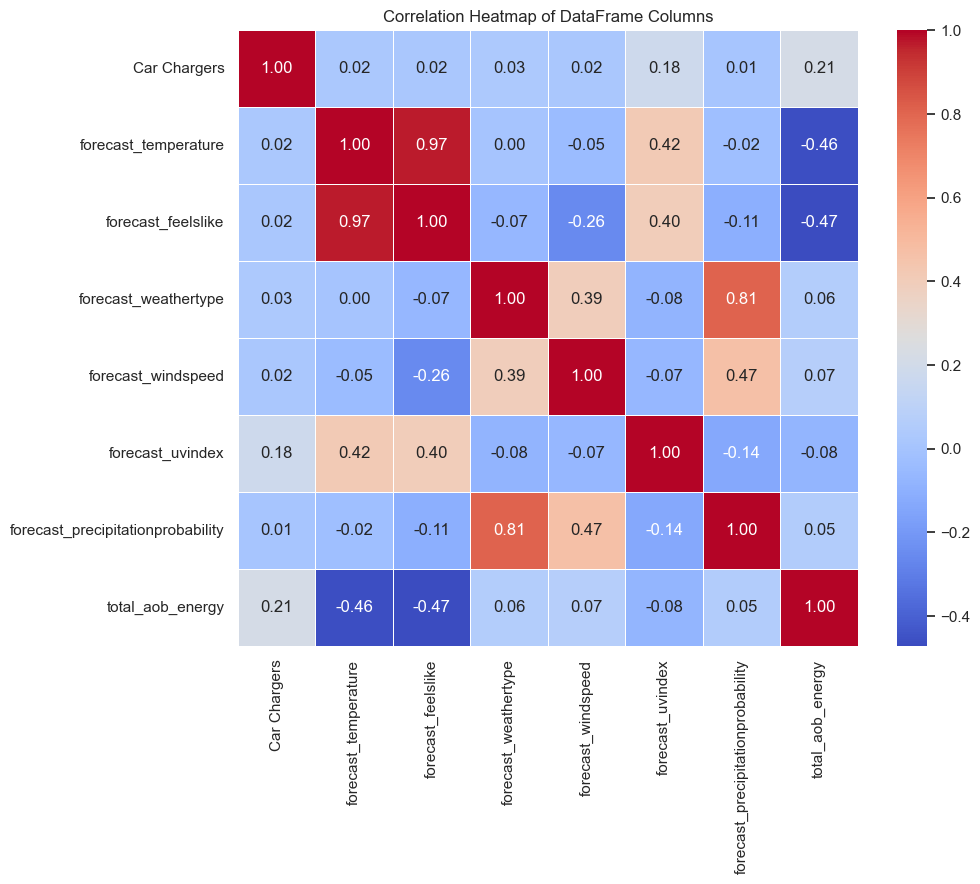

In [ ]:
# Calculate the correlation matrix
correlation_matrix1 = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()